In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

--------------------------------------------------------------------------------------------------------------------------------
###                                      Generation of Data      -         Synthetic Data
--------------------------------------------------------------------------------------------------------------------------------

In [131]:
# parameters of the (latent) gaussians
mus = (np.array([-2., -2.]), np.array([2., 2.]))
covs = (
    np.array([[0.5, 0.],[0., 0.5]]),
    np.array([[0.3, 0.1], [0.1, 0.3]]),
)

In [132]:
n_features = 2
n_classes = len(mus)
n_samples_per_class = 500

features = []
labels = []

for i in range(n_classes):
    features.append(
        np.random.multivariate_normal(mean=mus[i], 
                                      cov=covs[i],
                                      size=(n_samples_per_class,))
    )
    labels.append([i]*n_samples_per_class)

In [133]:
features_orig = np.array(features).reshape(n_classes*n_samples_per_class, n_features)
labels_orig = np.array(labels).reshape(n_classes*n_samples_per_class, 1).squeeze()

## View latent dataset

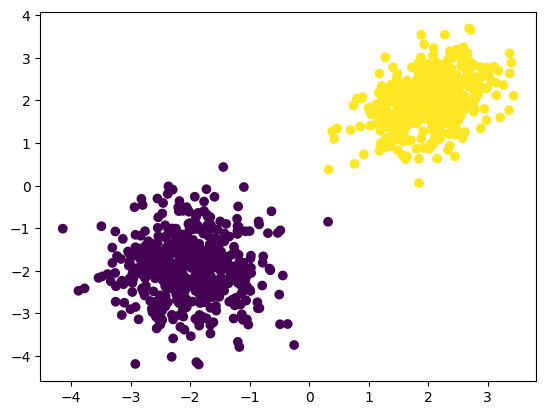

In [134]:
plt.scatter(
    features_orig[:,0], features_orig[:,1], c=labels_orig
)

In [135]:
def warp1(a):
    x = a[:,0]
    y = a[:,1]
    out1 = x*y
    out2 = x + np.exp(-y/10.)
    out3 = (np.log(x*x*y*y) + 10*x*x*y - x)/100.
    return np.stack((out1, out2, out3), axis=-1)

In [167]:
def warp2(a):
    x = a[:,0]
    y = a[:,1]
    out1 = np.log(x*x*y*y) + 10*x*y*np.sin(x)
    out2 = y - 10*x*y
    out3 = x*y*np.tan(y)
    out4 = x-y
    return np.stack((out1, out2, out3, out4), axis=-1)

In [168]:
warped_features_1 = warp1(features_orig)
warped_features_2 = warp2(features_orig)

## View dataset for client 1

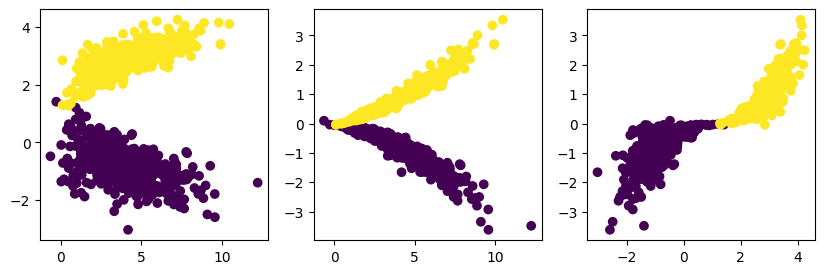

In [169]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].scatter(
    warped_features_1[:,0], warped_features_1[:,1], c=labels_orig
)
ax[1].scatter(
    warped_features_1[:,0], warped_features_1[:,2], c=labels_orig
)
ax[2].scatter(
    warped_features_1[:,1], warped_features_1[:,2], c=labels_orig
)

## View dataset for client 2

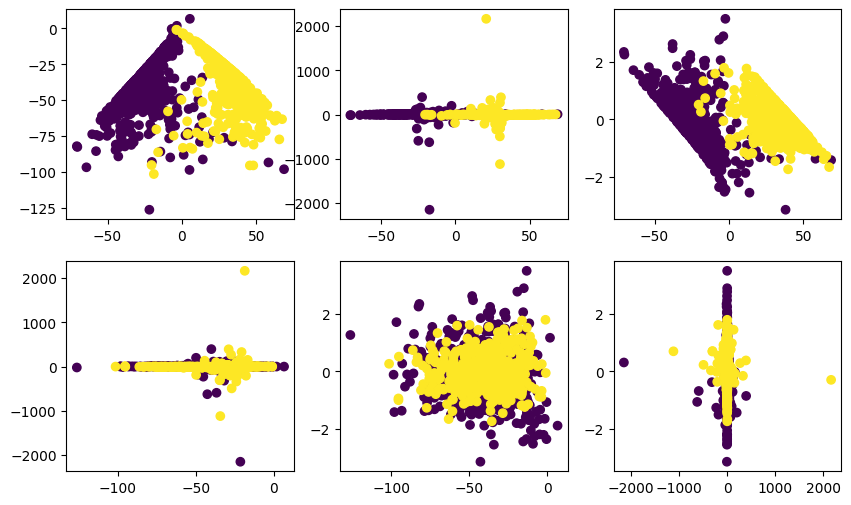

In [170]:
fig, ax = plt.subplots(2,3,figsize=(10,6))
ax[0][0].scatter(
    warped_features_2[:,0], warped_features_2[:,1], c=labels_orig
)
ax[0][1].scatter(
    warped_features_2[:,0], warped_features_2[:,2], c=labels_orig
)
ax[0][2].scatter(
    warped_features_2[:,0], warped_features_2[:,3], c=labels_orig
)
ax[1][0].scatter(
    warped_features_2[:,1], warped_features_2[:,2], c=labels_orig
)
ax[1][1].scatter(
    warped_features_2[:,1], warped_features_2[:,3], c=labels_orig
)
ax[1][2].scatter(
    warped_features_2[:,2], warped_features_2[:,3], c=labels_orig
)